In [1]:
import os
from astropy.io import fits
import numpy as np
from astropy.nddata import CCDData
from astropy.stats import mad_std
import ccdproc as ccdp
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.nddata.utils import Cutout2D, block_reduce
from astropy import visualization as aviz

In [2]:
# Define the paths to the images to easily access them later

main_path = "./images/"

# - For the SN2021hiz supernovae
sn2021hiz_bias        = main_path + "SN2021hiz/Bias/"
sn2021hiz_dark        = main_path + "SN2021hiz/Dark"
sn2021hiz_flat_clear  = main_path + "SN2021hiz/Flat/Clear"
sn2021hiz_flat_SA     = main_path + "SN2021hiz/Flat/SA"
sn2021hiz_light_clear = main_path + "SN2021hiz/Light/Clear"
sn2021hiz_light_SA    = main_path + "SN2021hiz/Light/SA"

In [3]:
# Define some parameters useful for running the code
main_path = "./images/"

                
pars = {"paths"   : { "Bias"                   : main_path + "SN2021hiz/Bias/",
                      "Dark"                   : main_path + "SN2021hiz/Dark",
                      "Flat"                   : main_path + "SN2021hiz/Flat/Clear",
                      "Light"                  : main_path + "SN2021hiz/Light/Clear",
                      "comb_out"               : "./images/SN2021hiz/Combinations/",
                      "red_darks"              : "./images/SN2021hiz/Reductions/DarkReduced",
                      "red_lights"             : "./images/SN2021hiz/Reductions/LightReduced",
                      "red_flats"              : "./images/SN2021hiz/Reductions/FlatReduced"},
        
        "combine" : { "method"                 : 'average',
                      "sigma_clip_low_thresh"  : 5,
                      "sigma_clip_high_thresh" : 5,
                      "sigma_clip_func"        : np.ma.median,
                      "sigma_clip_dev_func"    : mad_std,
                      "unit"                   : 'adu'}
}

In [4]:
def open_ccd_image(file_name, unit):
    im = CCDData(fits.getdata(file_name), meta=fits.getheader(file_name), unit = unit)
    return im

def make_path(path):
    if not os.path.exists(path): os.system("mkdir -p %s"%path)
    return

def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.
    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        


In [5]:
outpath = "./results/"
make_path(outpath)
# Open the output files to easily work with them

uncal_bias = open_ccd_image(pars["paths"]["Bias"] + '/' + os.listdir(pars["paths"]["Bias"])[0], \
                             pars["combine"]["unit"])

uncal_dark = open_ccd_image(pars["paths"]["Dark"] + '/' + os.listdir(pars["paths"]["Dark"])[0], \
                             pars["combine"]["unit"])
 
uncal_flat = open_ccd_image(pars["paths"]["Flat"] + '/' + os.listdir(pars["paths"]["Flat"])[0], \
                             pars["combine"]["unit"])

uncal_light = open_ccd_image(pars["paths"]["Light"] + '/' + os.listdir(pars["paths"]["Light"])[0], \
                             pars["combine"]["unit"])


master_bias = open_ccd_image(pars["paths"]["comb_out"] + '/' + 'combined_bias.fits', \
                             pars["combine"]["unit"])

master_dark = open_ccd_image(pars["paths"]["comb_out"] + '/' + 'combined_dark.fits', \
                             pars["combine"]["unit"])

master_flat = open_ccd_image(pars["paths"]["comb_out"] + '/' + 'combined_flat.fits', \
                             pars["combine"]["unit"])

master_light = open_ccd_image(pars["paths"]["comb_out"] + '/' + 'Calibrated_lights_stacked.fit',\
                              pars["combine"]["unit"])

deepsky_light = open_ccd_image(pars["paths"]["comb_out"] + '/' + 'FilterSN.FTS',\
                               pars["combine"]["unit"])



In [112]:
def compare_two_images(image1, image2, title_1, title_2, saveAs, percl1 = 99.9, percl2 = 99.9):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    show_image(image1, cmap='gray', ax=ax1, fig=fig, percl = percl1)
    ax1.set_title(title_1)
    
    show_image(image2, cmap='gray', ax=ax2, fig=fig, percl = percl2)
    ax2.set_title(title_2)
    
    fig.savefig(saveAs + ".png")
    fig.savefig(saveAs + ".pdf")
    
    return

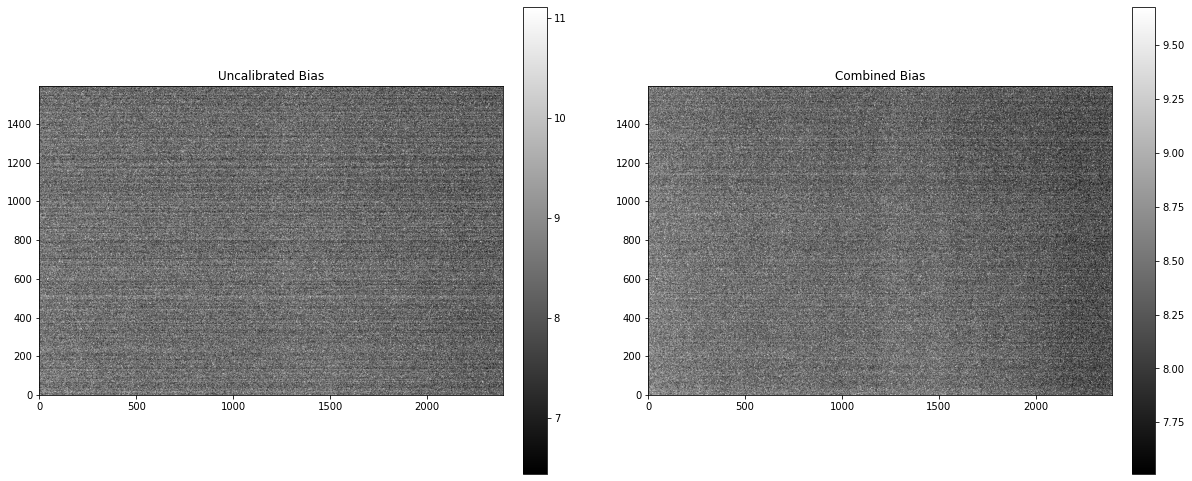

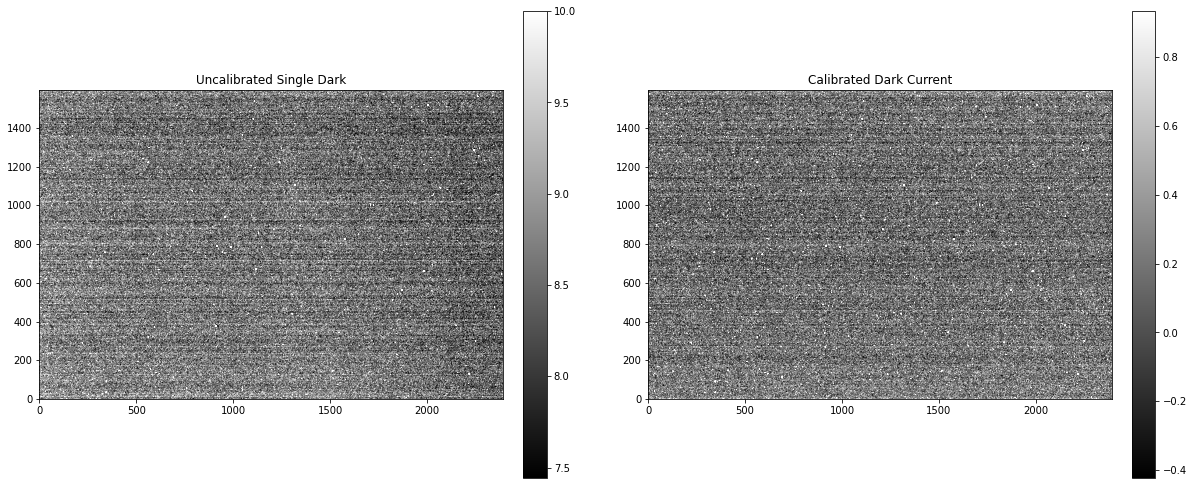

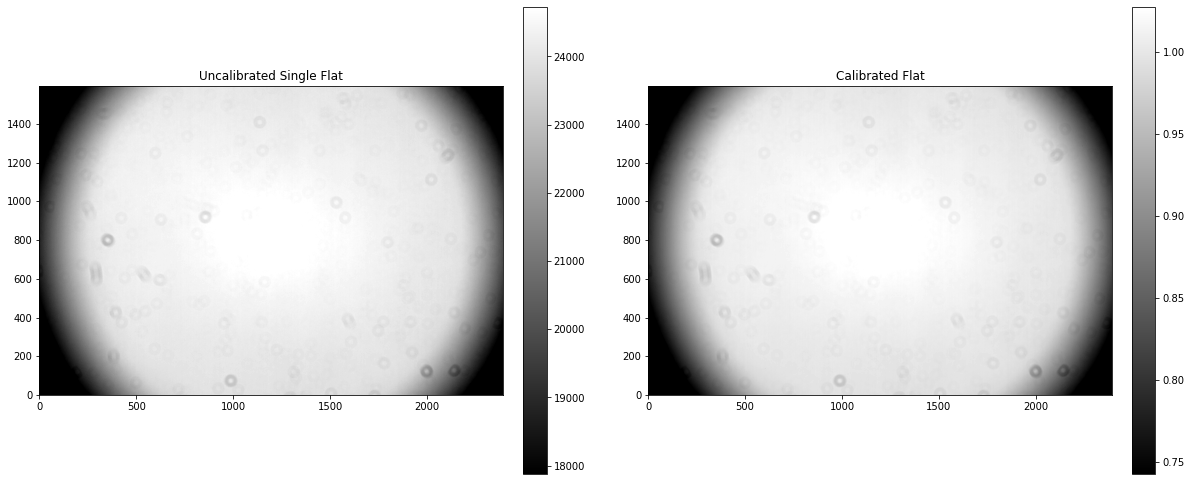

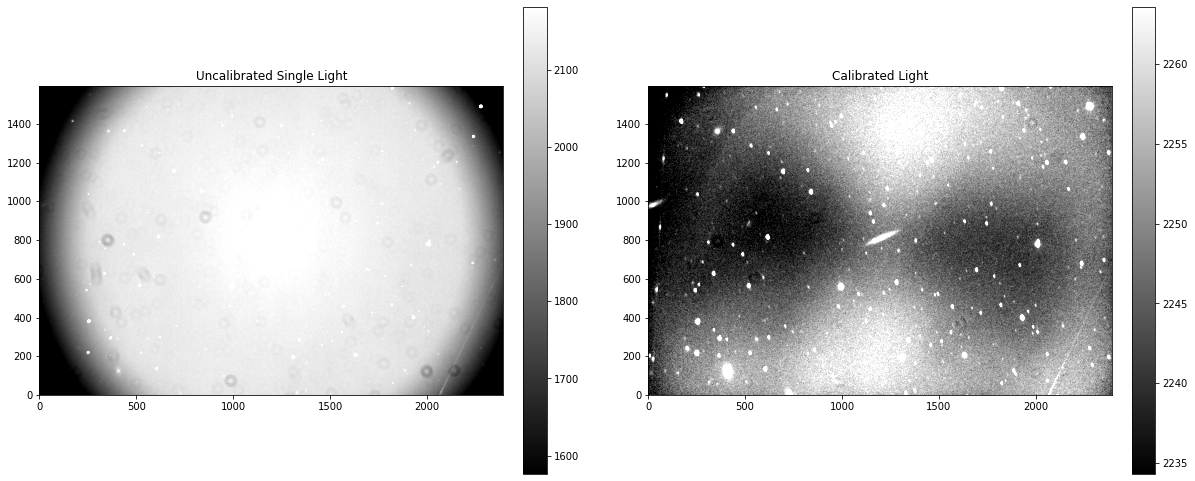

In [114]:
compare_two_images(uncal_bias, master_bias, "Uncalibrated Bias", "Combined Bias", outpath + "bias_comparison", 99.9, 99.9)
compare_two_images(uncal_dark, master_dark, "Uncalibrated Single Dark", "Calibrated Dark Current", outpath +\
                   "dark_comparison", 95.5, 95.5)
compare_two_images(uncal_flat, master_flat, "Uncalibrated Single Flat", "Calibrated Flat", outpath +\
                   "flat_comparison",95.5, 95.5)
compare_two_images(uncal_light, master_light, "Uncalibrated Single Light", "Calibrated Light", outpath +\
                   "light_comparison", 95.5, 95.5)

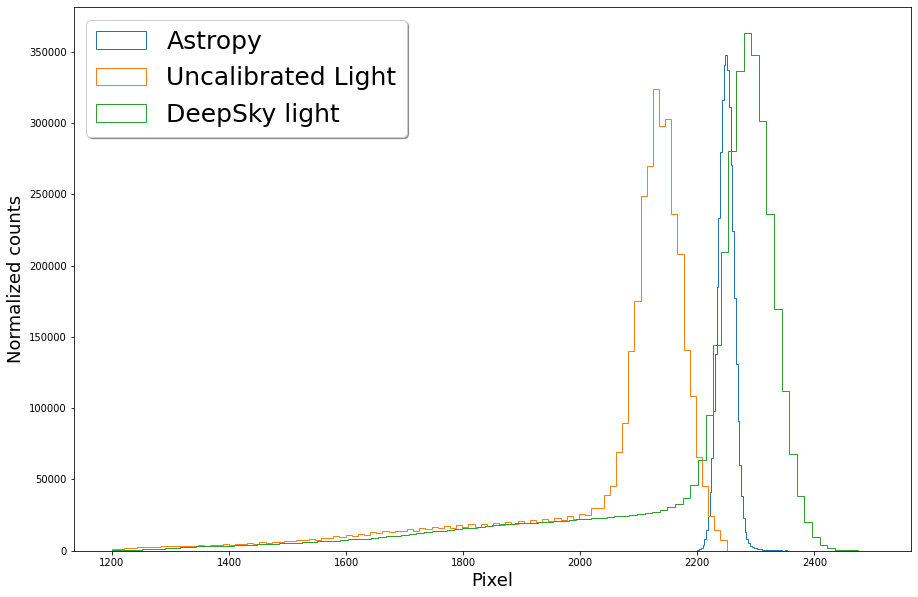

In [109]:
# Plot some histograms to see the distributions
Nbins = 100
fig = plt.figure(figsize = (15, 10))
axes = fig.add_subplot(111)

axes.set_ylabel('Normalized counts', fontsize=18)
axes.set_xlabel('Pixel', fontsize=18)


ml_hist, ml_bins, _ = plt.hist(master_light.data.flatten(), bins = Nbins,\
                               range = (2200, 2500), histtype = 'step', label = 'Astropy')


ucall_hist, ucall_bins, _ = plt.hist(uncal_light.data.flatten(), bins = Nbins,\
                               range = (1200, 2250), histtype = 'step', label = 'Uncalibrated Light')

dsl_hist, dsl_bins, _ = plt.hist(deepsky_light.data.flatten(), bins = Nbins,\
                               range = (1200, 2500), histtype = 'step', label = 'DeepSky light')

# Fit the distributions
x_th = np.linspace(1200, 2500, 1000)
ml_centers    = get_bin_centers(ml_bins)
ucall_centers = get_bin_centers(ucall_bins)
dsl_centers    = get_bin_centers(dsl_bins)

plt.legend(loc = 'upper left', shadow = True, prop={'size': 25})
fig.savefig(outpath + 'comparison_histograms.png')
fig.savefig(outpath + 'comparison_histograms.pdf')
plt.show()

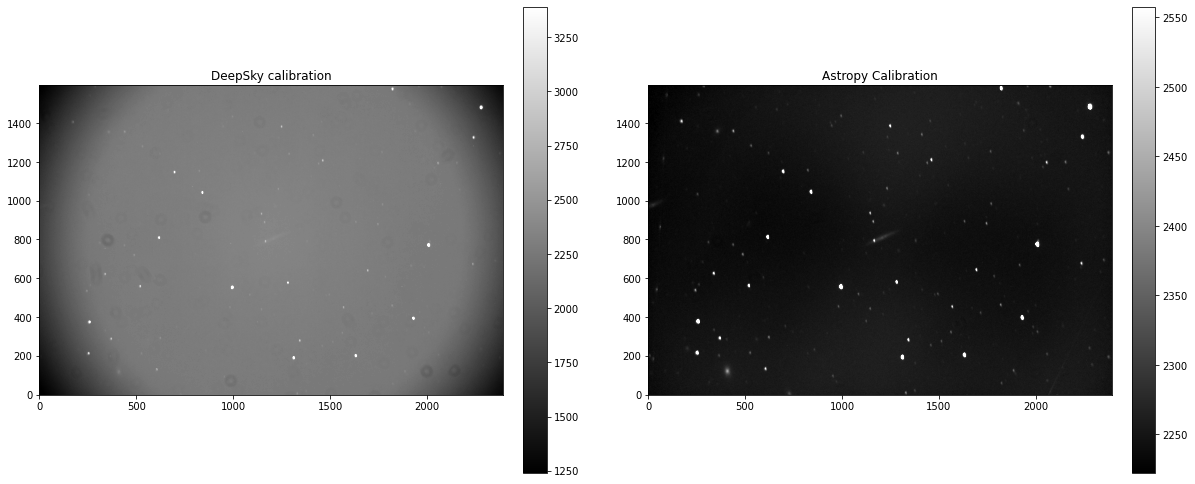

In [131]:
compare_two_images(deepsky_light, master_light, "DeepSky calibration", "Astropy Calibration", outpath +\
                   "method_comparison",99.97, 99.9)